# CarND Vehicle Detection Project

Vehicle Detection Project 

The goals / steps of this project are the following:
1. Explore Dataset & Color Spaces
2. Make Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM (Support Vector Machine) classifier. Combine the HOG feature vector with color transform and binned color features
3. Implement sliding-window scheme to search for cars using the trained SVM
4. Creation heatmap function for detections in subsequent framens of a video stream to reject faulse positives and follow detected vehicles.


The goal of our project is to find road vehicles on images and to track its on video. Ащк еру зкщоусе Ш гыу the histogram of oriented gradients (HOG) and support vector machines (SVM). 
In the begining I trained a vehicle classification model using Linear SVM algorithm.
Then I extracted the features using the HOG, Color Histograms and Special Binning schemes 
After I used sliding window scheme to extract image areas patches from full road images. These image areas were used to extract features. I checked these features on SVM model to find out whether this area contain vehicle.
Then I used hot map scheme to remove duplicates and false positives. 
Detected vehicles were drawn by bounding boxes to indicate its on images.
Then I implemented pipeline on video.

# 1. Explore Dataset & Color Spaces

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
import pickle

In [2]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation



def plot_3d_utility(file_name):
    print (file_name)
    #feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img = cv2.imread(file_name)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.show()
    return   

video_frames\frame000275.png


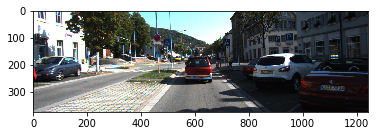

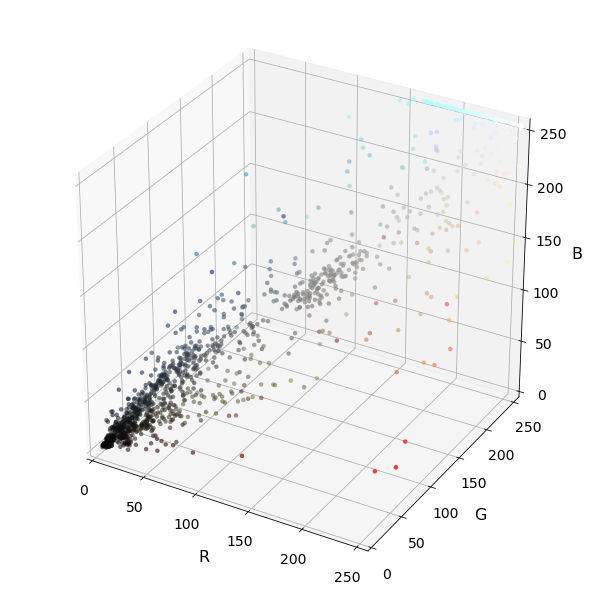

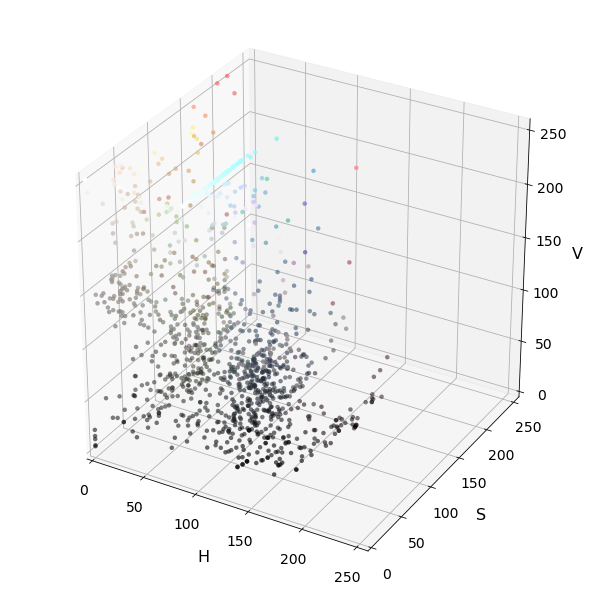

video_frames\frame000528.png


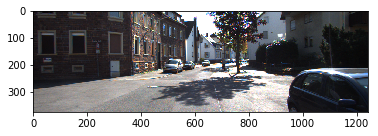

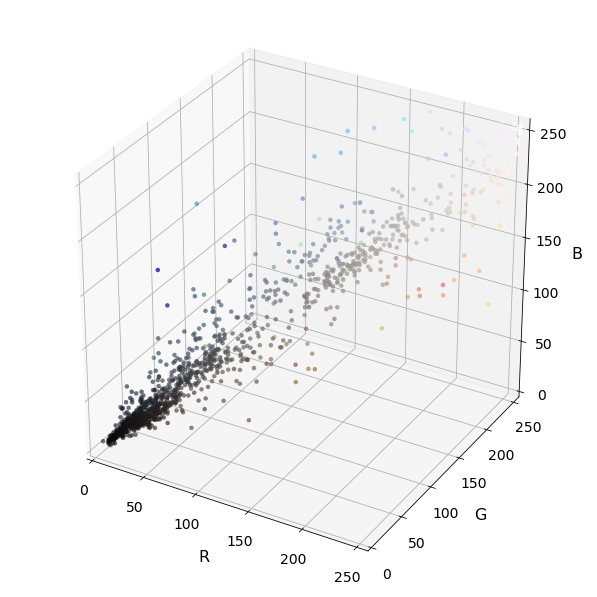

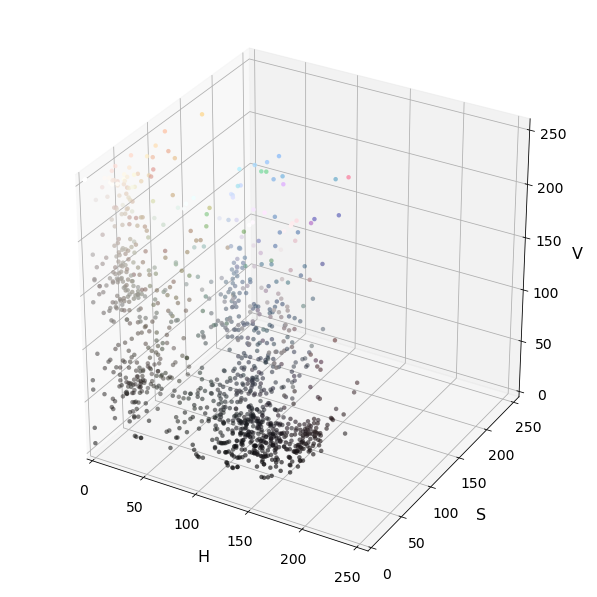

video_frames\frame001240.png


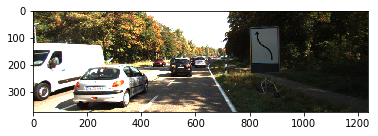

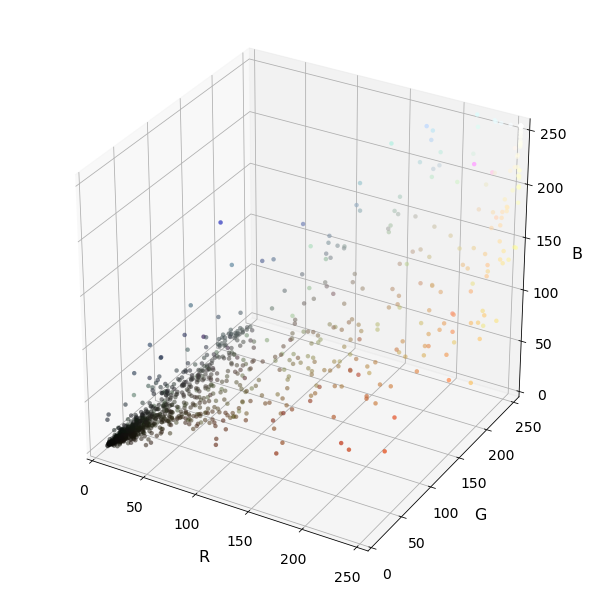

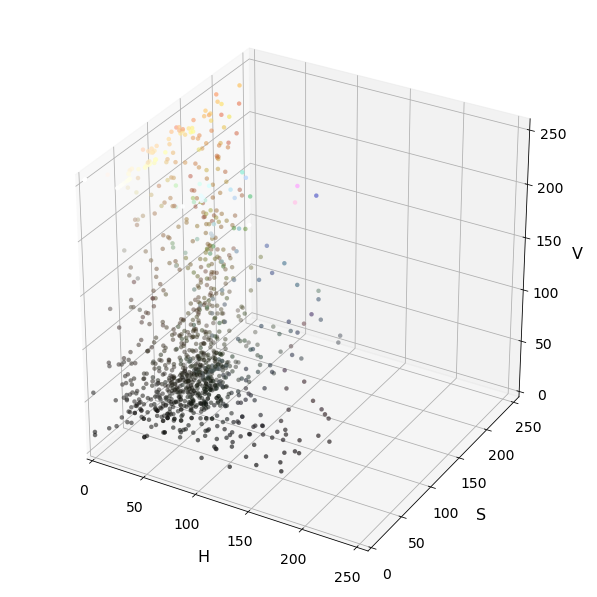

In [3]:
# Load a list of images
frames = glob.glob('video_frames/frame*.png')

for frame in frames:
     
    plot_3d_utility(frame)

['video_frames\\cut2.png', 'video_frames\\cut25.png', 'video_frames\\cut3.png', 'video_frames\\cut31.png', 'video_frames\\cut53.png', 'video_frames\\cut8.png']
video_frames\cut2.png


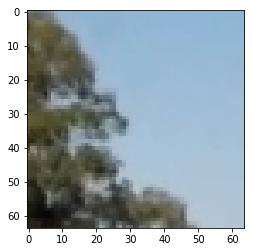

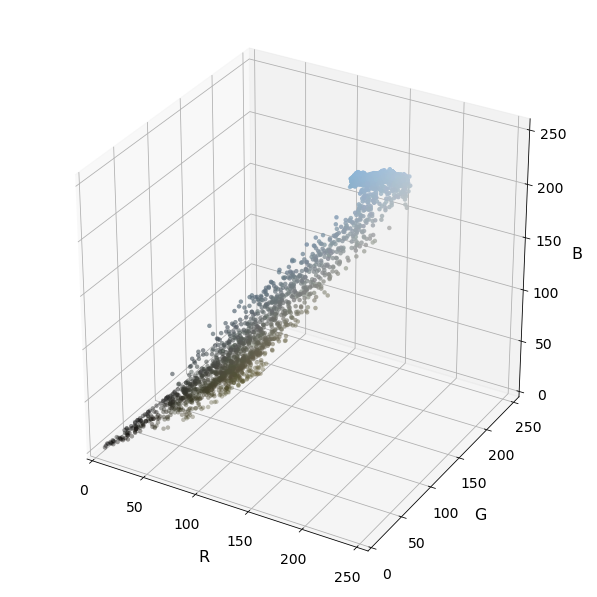

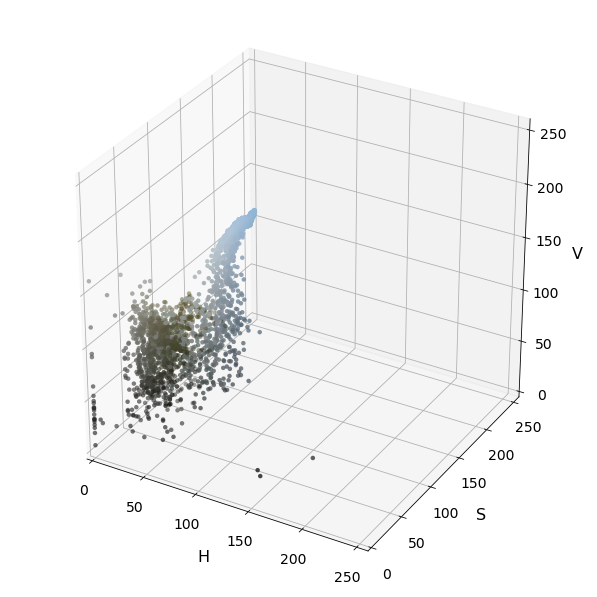

video_frames\cut25.png


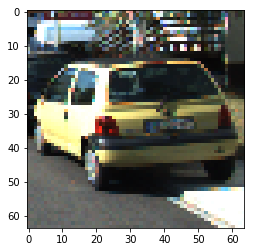

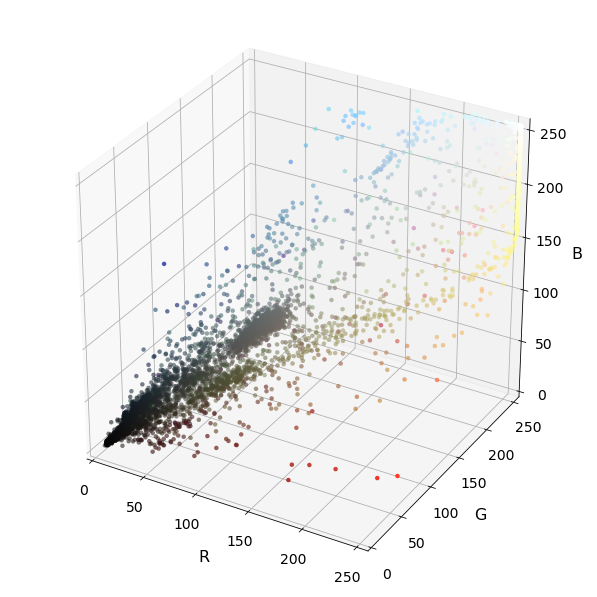

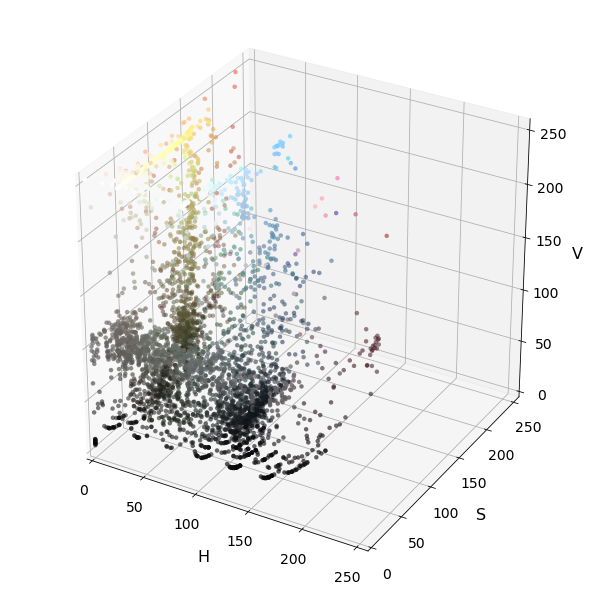

video_frames\cut3.png


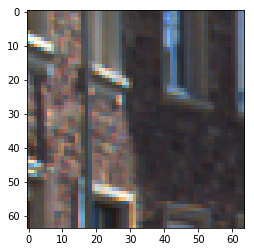

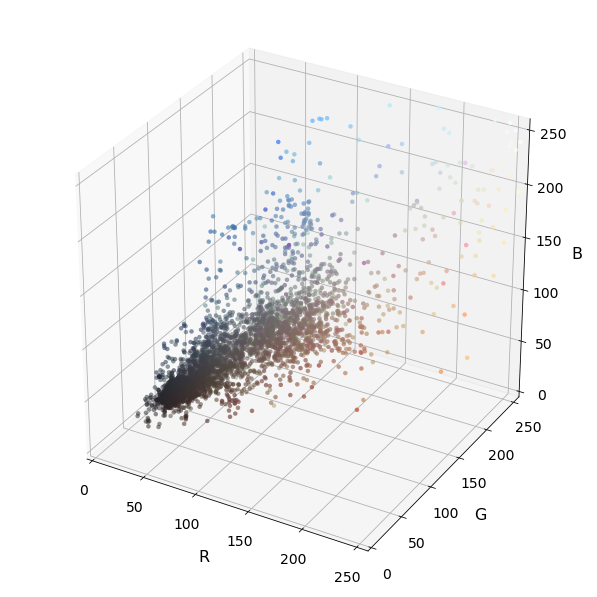

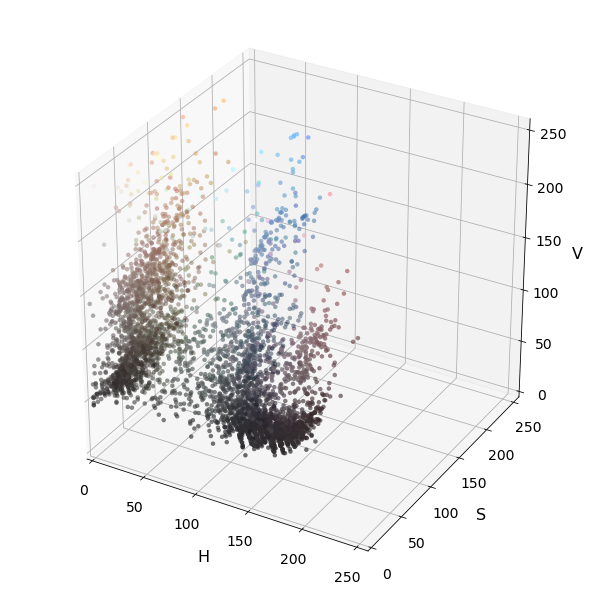

video_frames\cut31.png


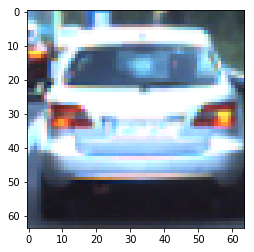

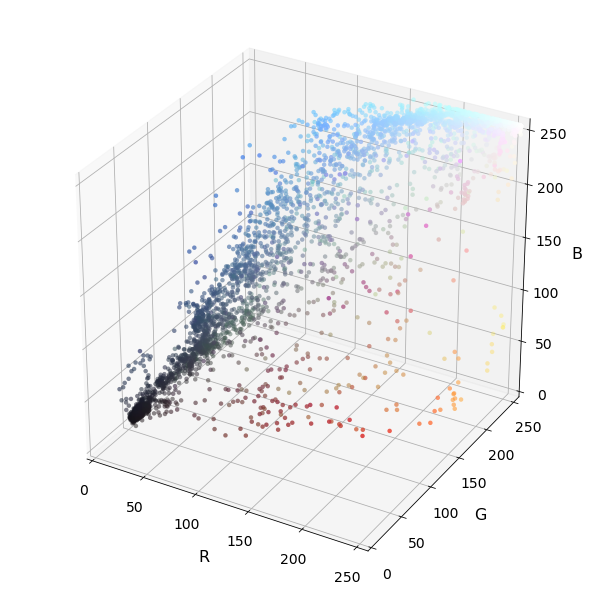

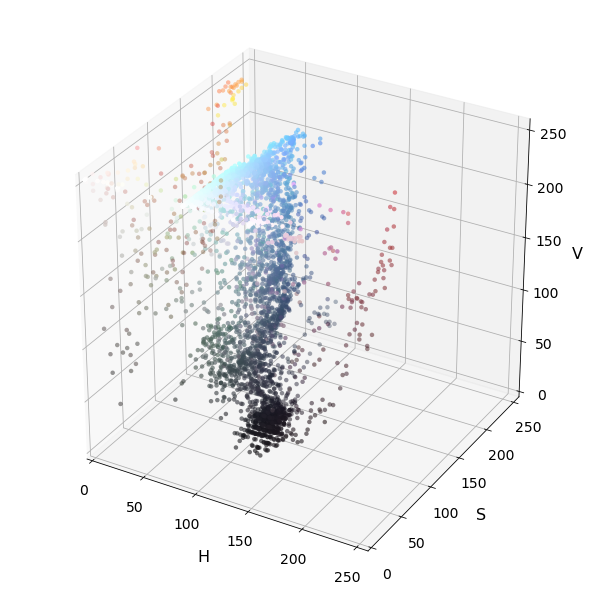

video_frames\cut53.png


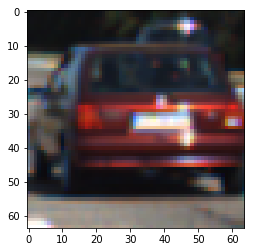

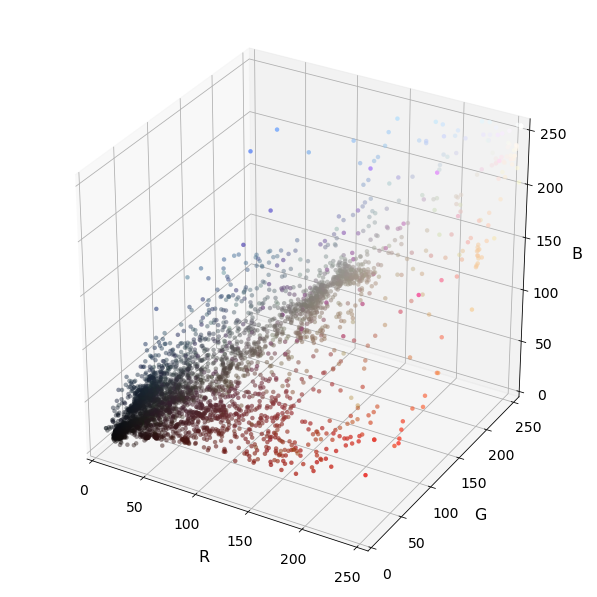

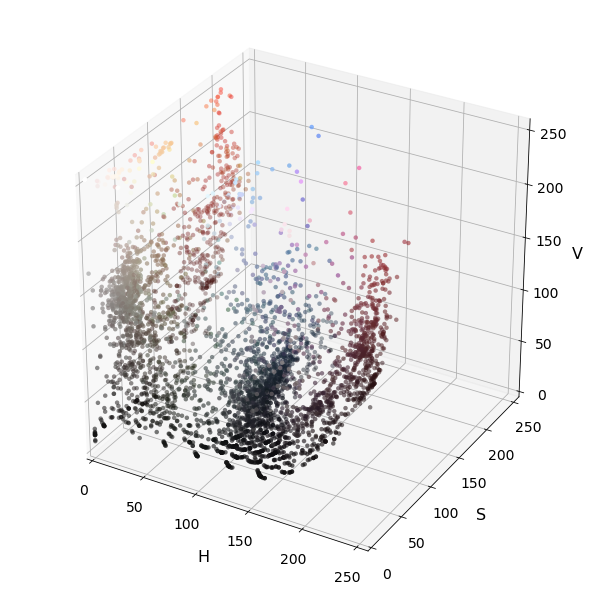

video_frames\cut8.png


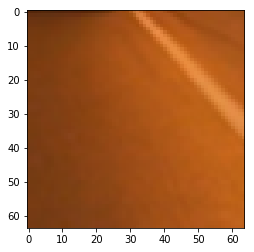

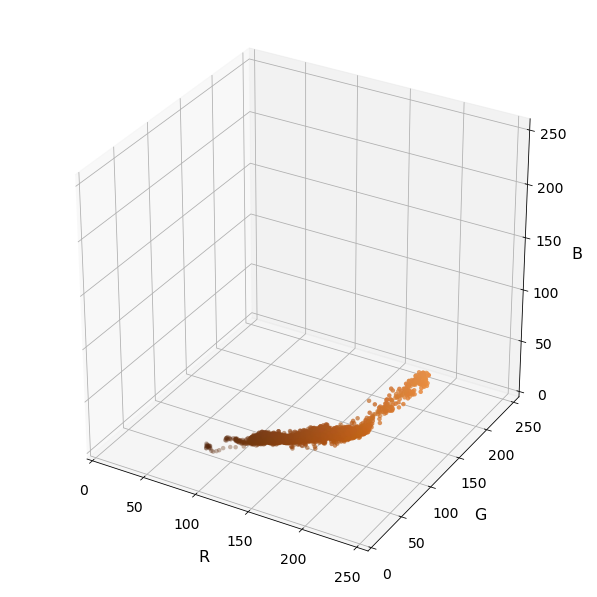

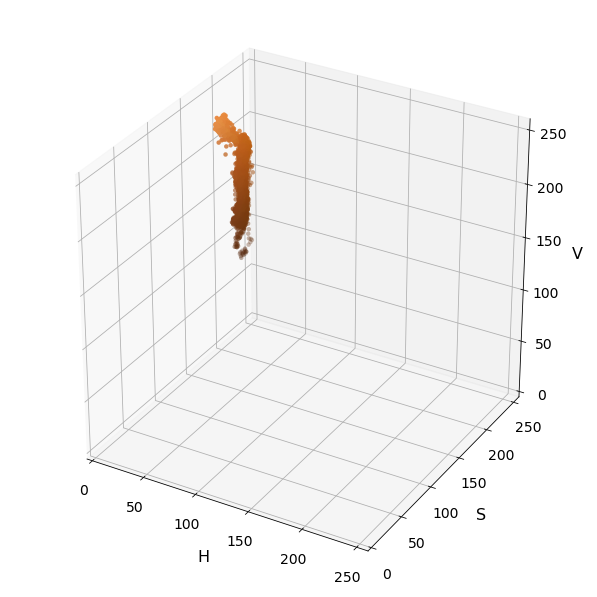

In [4]:
# Load a list of images
cuts = glob.glob('video_frames/cut*.png')
print (cuts)
for cut in cuts:
     
    plot_3d_utility(cut)

In [5]:
# 
image = mpimg.imread('test_img.jpg')
small_img = cv2.resize(image, (32, 32))
print('Full image shape', image.shape)
print('Small image shape', small_img.shape)
feature_vec = small_img.ravel()
print('Feature vector shape', feature_vec.shape)

Full image shape (130, 130, 3)
Small image shape (32, 32, 3)
Feature vector shape (3072,)


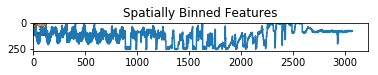

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('test_img.jpg')
plt.imshow(image)
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

In [7]:
import os

def extract_files(parent, extension):
    """

    :param parent:
    :param extension:
    :return:
    """
    file_container = []
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith(extension):
                file_container.append(os.path.join(root, file))
    return file_container


vehicle_files_dir = './data/vehicles/'
non_vehicle_files_dir = './data/non-vehicles/'
extension = '.png'
vehicle_files = extract_files(vehicle_files_dir, extension)
vehicle_images = [mpimg.imread(file) for file in vehicle_files]

non_vehicle_files = extract_files(non_vehicle_files_dir, extension)
non_vehicle_images = [mpimg.imread(file) for file in non_vehicle_files] 
print ('Big dataset')
print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))


vehicle_files_dir = './data/vehicles_smallset/'
non_vehicle_files_dir = './data/non-vehicles_smallset/'
extension='.jpeg'
vehicle_files = extract_files(vehicle_files_dir, extension)
vehicle_images = [mpimg.imread(file) for file in vehicle_files]

non_vehicle_files = extract_files(non_vehicle_files_dir, extension)
non_vehicle_images = [mpimg.imread(file) for file in non_vehicle_files] 

print ('Small dataset')
print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

Big dataset
Number of vehicle files: 8792
Number of non-vehicle files: 8968
Small dataset
Number of vehicle files: 1196
Number of non-vehicle files: 1125


Number of cars:  1196
Number of notcars:  1125


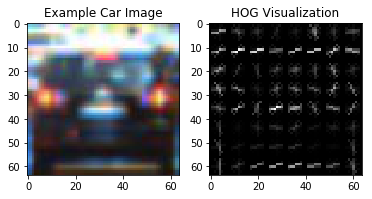

In [8]:

from skimage.feature import hog

# Read in our vehicles and non-vehicles
images = glob.glob('./data/samples/*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
print ('Number of cars: ', len(cars))
print ('Number of notcars: ',len(notcars))

ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

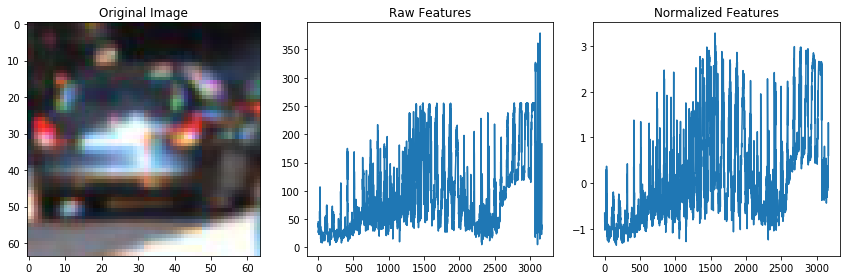

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


images = glob.glob('./data/samples/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

### Load full dataset
We load vehicles and non-vehicles to dataset directory.


In [10]:
import os

def extract_files(parent, extension):
    """

    :param parent:
    :param extension:
    :return:
    """
    file_container = []
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith(extension):
                file_container.append(os.path.join(root, file))
    return file_container


vehicle_files_dir = './data/vehicles/'
non_vehicle_files_dir = './data/non-vehicles/'
extension = '.png'
vehicle_files = extract_files(vehicle_files_dir, extension)
vehicle_images = [mpimg.imread(file) for file in vehicle_files]

non_vehicle_files = extract_files(non_vehicle_files_dir, extension)
non_vehicle_images = [mpimg.imread(file) for file in non_vehicle_files] 
print ('Load Big dataset')
print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

Load Big dataset
Number of vehicle files: 8792
Number of non-vehicle files: 8968


# 2. Make Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM (Support Vector Machine) classifier. Combine the HOG feature vector with color transform and binned color features

I try different combinations of parameters - color spaces and HOG options.
The most valuable is HLS color space. RGB color space is not relyable because it is too dependant from changing light conditions. YUV and YCrCb is also not very stable. 
I choose HLS colour pace and value of pixels_per_cell=(8,8). 
Using values larger than cells_per_block=(2,2) did not improve results substancially.
I used a linear SVM with all channels of images. I included spatial features color features as well as all three HLS channels.
For color binning I use spatial_size=(16,16). For color histograms I used hist_bins=32.
Test Accuracy of SVC =  0.9906

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Divide up into cars and notcars
#cars_images = glob.glob('./data/samples/*.jpeg')
#non_cars_images = 
cars = []
notcars = []
for image in vehicle_files:
    cars.append(image)
for image in non_vehicle_files:
    notcars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins=32
spatial_feat=True
hist_feat=True
hog_feat=True

t=time.time()
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)



t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

84.1 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
7.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9906
My SVC predicts:      [ 0.  0.  0.  1.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  0.  1.  1.  0.  0.]
0.0 Seconds to predict 10 labels with SVC


Saving HOG classifier data to pickle file

In [12]:
pickle_file = 'ClassifierData.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {   'svc':svc, 
                'X_scaler': X_scaler,
                'color_space': color_space,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


# 3. Implement sliding-window scheme to search for cars using the trained SVM

I used a scheme with 4 overlapping zones and different sliding window sizes to detect cars of different sizes on image. 
I choose the following window sizes: 240,180,120 and 70 pixels.
Overlapping for same size windows is 75%.
Search_all_scales(image) function is used to search over all zones.

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import imageio
#imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from scipy.ndimage.measurements import label

In [14]:
# Load the classifier and parameters
data_file = 'ClassifierData.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

In [15]:
images = glob.glob('test_images/test*.png')
#images

In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

    



def search_all_scales(image):
    
    hot_windows = []
    all_windows = []
    #Y_start_stop =[[300,460]]
    #XY_window = [(150,150)]
    #X_start_stop =[[None,None]]    
    #X_start_stop =[[None,None],[None,None],[None,None]]    
    #Y_start_stop =[[390,440],[400,560],[400,560]]    
    #XY_window = [(80,80),(110,110),(130,130)]

    X_start_stop =[[None,None],[None,None]]    
    Y_start_stop =[[390,470],[390,500]]    
    XY_window = [(64,64),(110,110)]
    XY_overlap=[(0.75, 0.75),(0.75, 0.75)]

    X_start_stop =[[None,None],[None,None],[None,None],[None,None]]
    w0,w1,w2,w3 = 240,180,120,70
    o0,o1,o2,o3 = 0.75,0.75,0.75,0.75
    XY_window = [(w0,w0),(w1,w1),(w2,w2),(w3,w3)]
    XY_overlap = [(o0,o0),(o1,o1),(o2,o2),(o3,o3)]
    yi0,yi1,yi2,yi3 = 380,380,395,405                  
    Y_start_stop =[[yi0,yi0+w0/2],[yi1,yi1+w1/2],[yi2,yi2+w2/2],[yi3,yi3+w3/2]]    
    
    
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        
        hot_windows +=  search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows,all_windows

0.84 Seconds to search windows ...


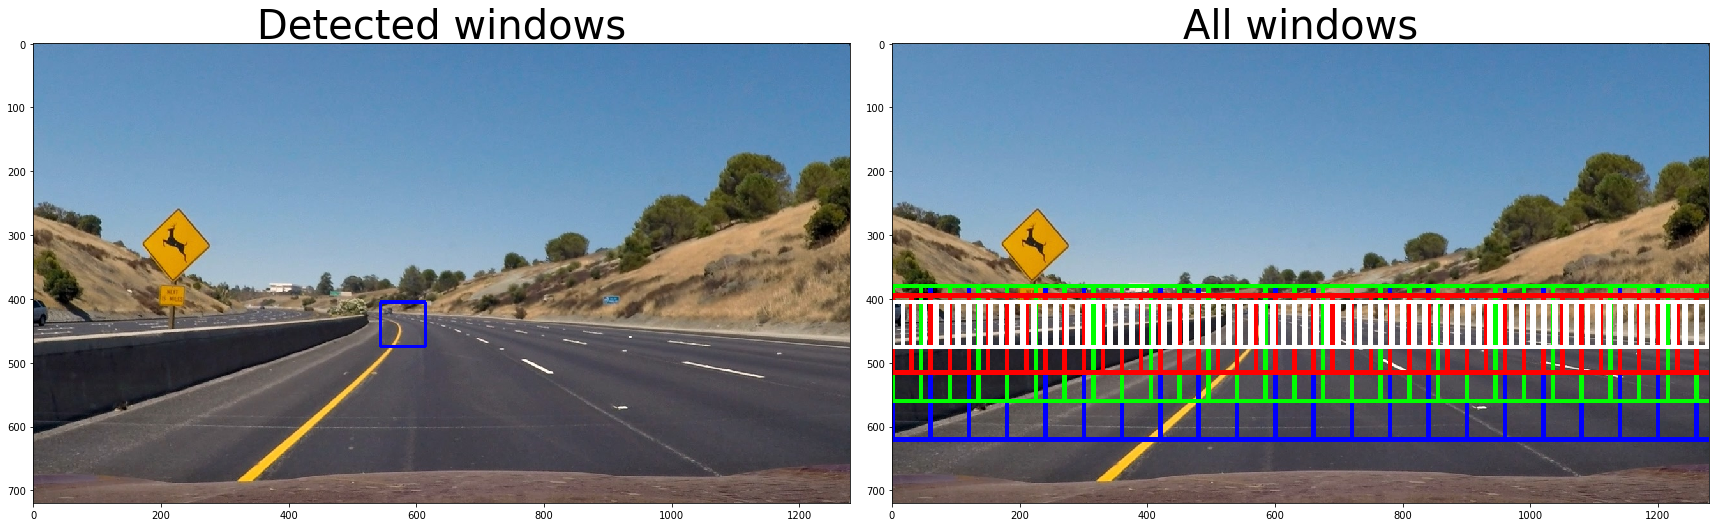

0.94 Seconds to search windows ...


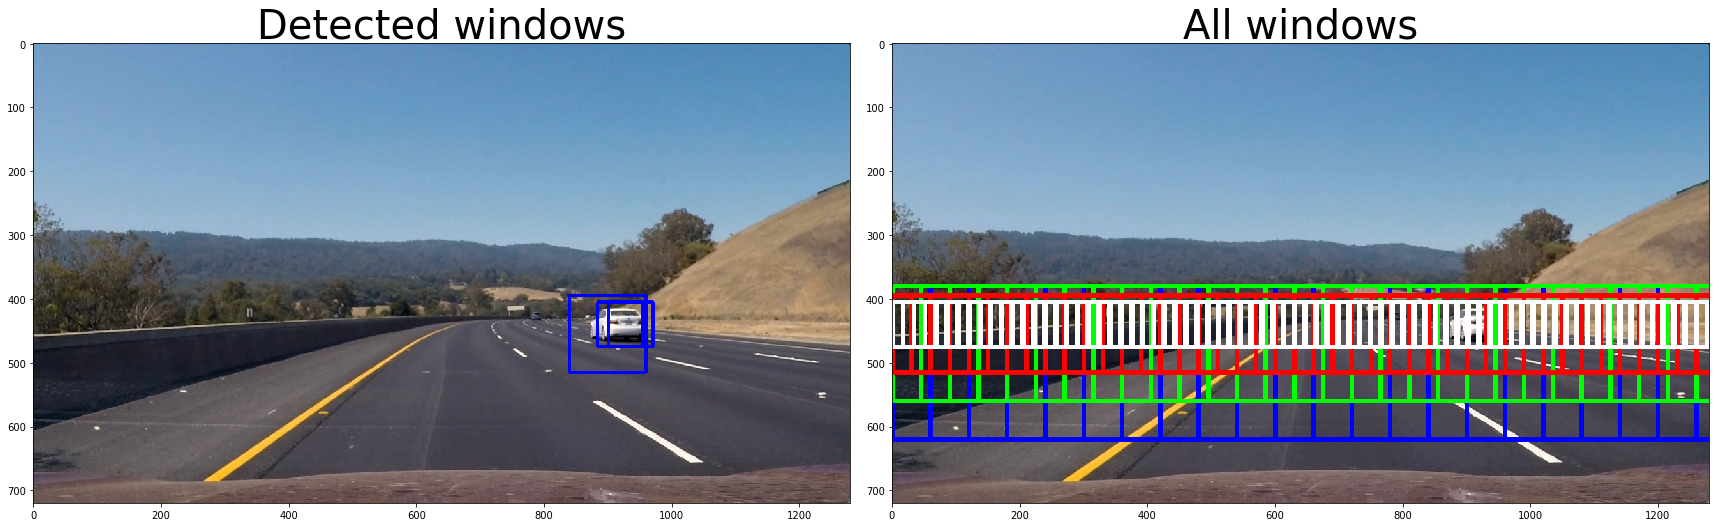

0.94 Seconds to search windows ...


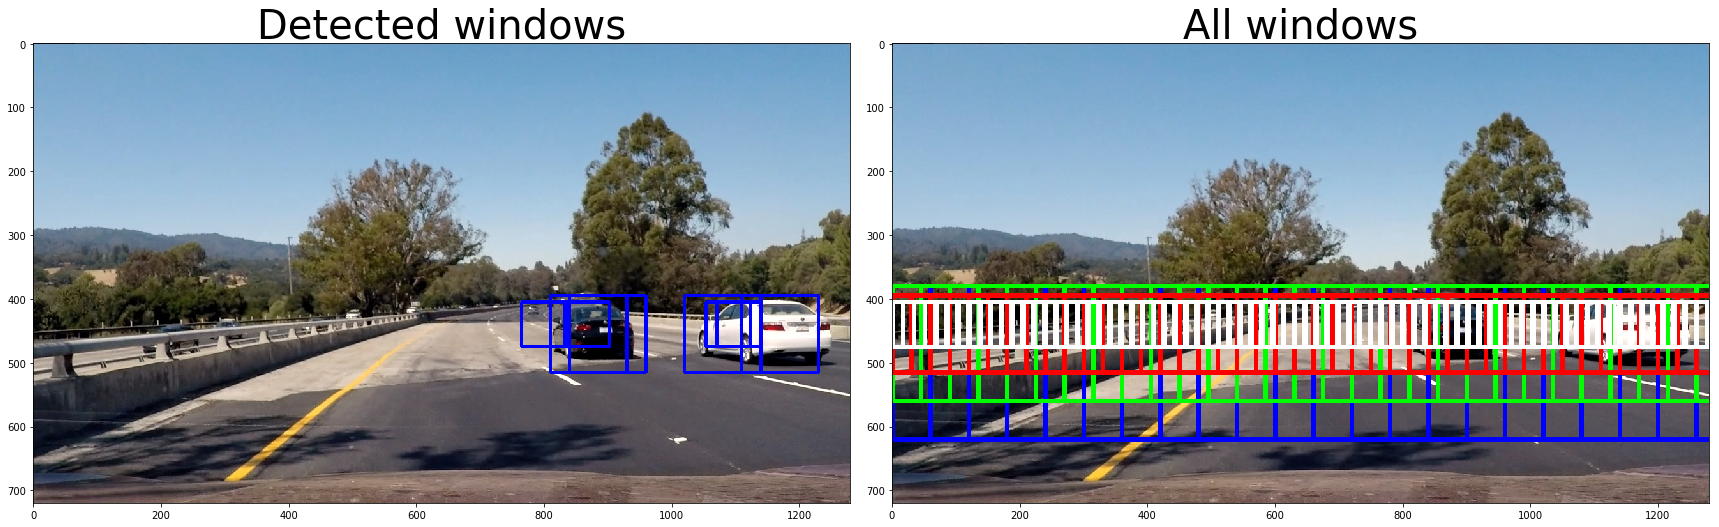

1.34 Seconds to search windows ...


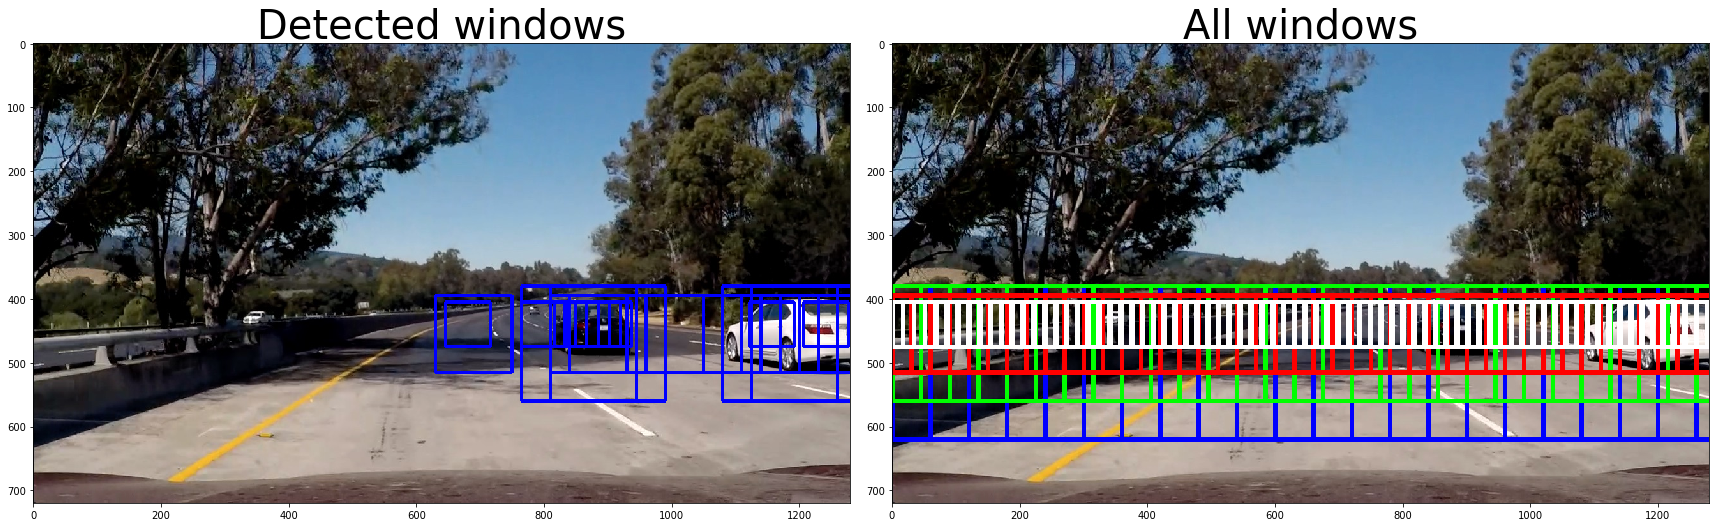

In [17]:
for file in images[1:5]:
    image = mpimg.imread(file)
    #image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    

    
    
    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
    
    
    
    plt.figure()    
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=40)
    plt.show()
    

# 5. Creation heatmap function for detections in subsequent framens of a video stream to reject faulse positives and follow detected vehicles.

In the class BoundingBoxes we implement a FIFO queue that collect the bounding boxes of the last n frames. 
We add list of detected bounding boxes to every frame to the beginning of the queueю
The oldest list of bounding boxes are destroyed.
This queue is then used in the processing of the video. It contains information about the last n=20 frames. Thus we use the threshold 20. It eliminate false positives.
From the positive detections we create a heatmap and then thresholded that map to identify vehicle positions.
After that we used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. Each blob corresponds to a vehicle. 
At the very end we draw bounding boxes to cover the area of each blob detected.

In [18]:
# Define a class to receive the characteristics of bounding box detections
class BoundingBoxes:
    def __init__(self,n=10):
        # length of queue to store data
        self.n = n
        # hot windows of the last n images
        self.recent_boxes = deque([],maxlen=n)
        # current boxes
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()
                
        
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    if bbox_list:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


1.12 Seconds to search windows ...
1.18 Seconds to search windows ...
0.73 Seconds to search windows ...
0.96 Seconds to search windows ...


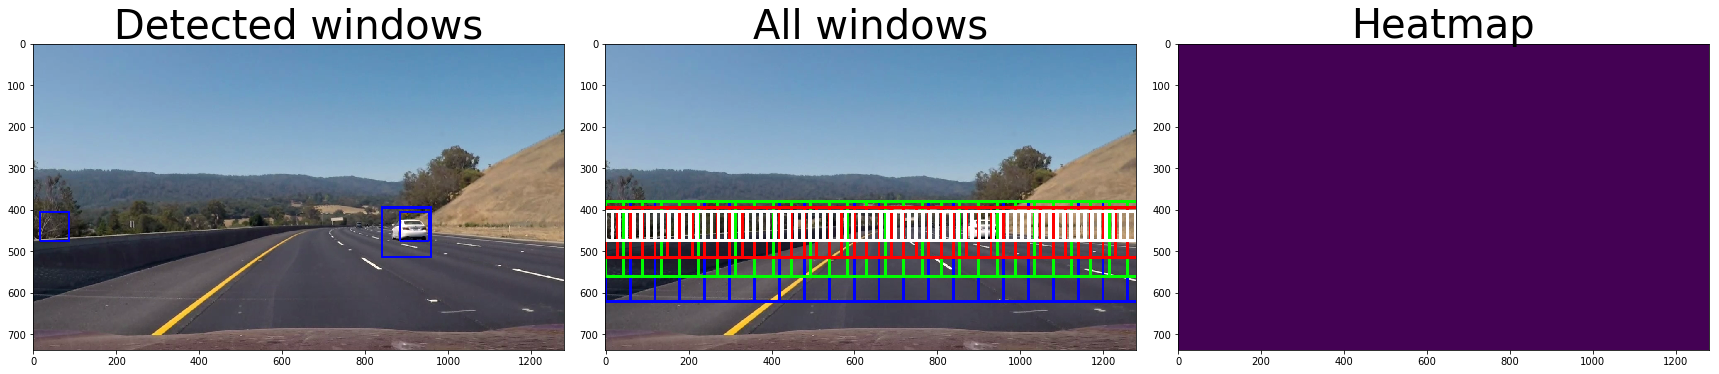

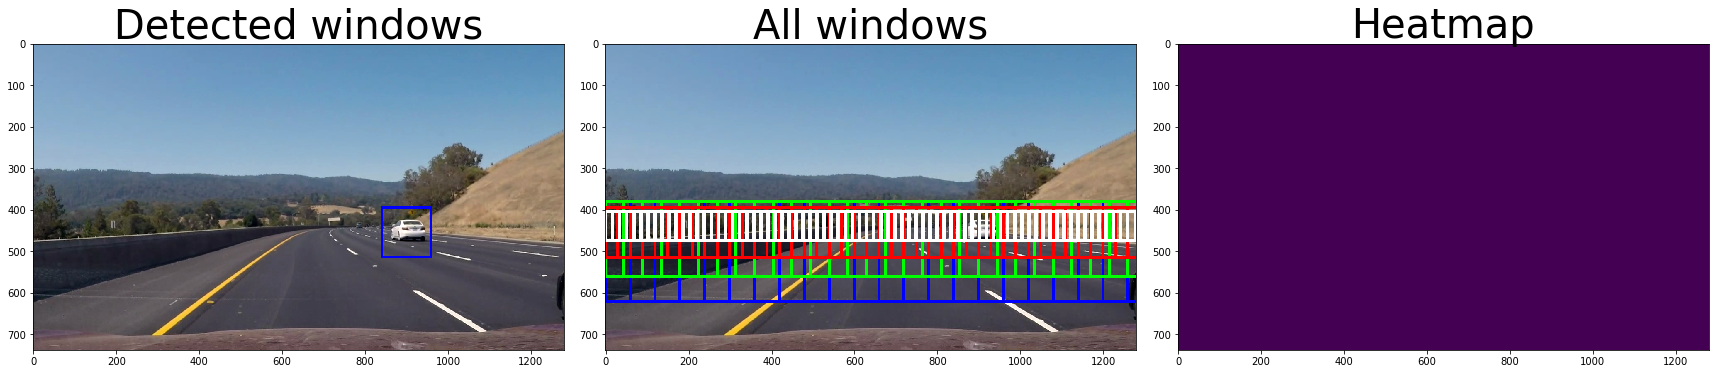

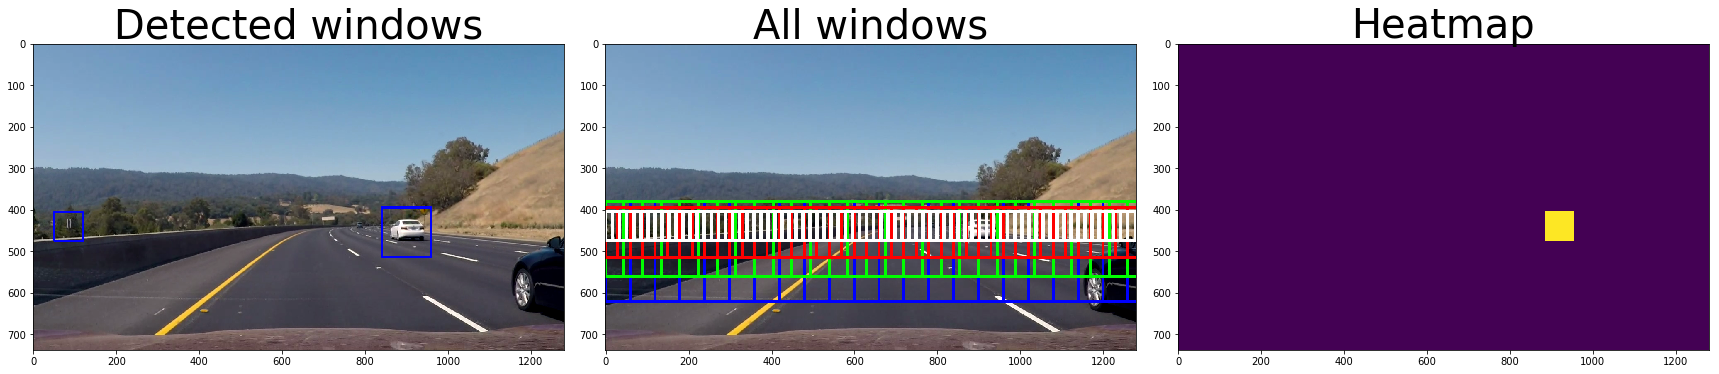

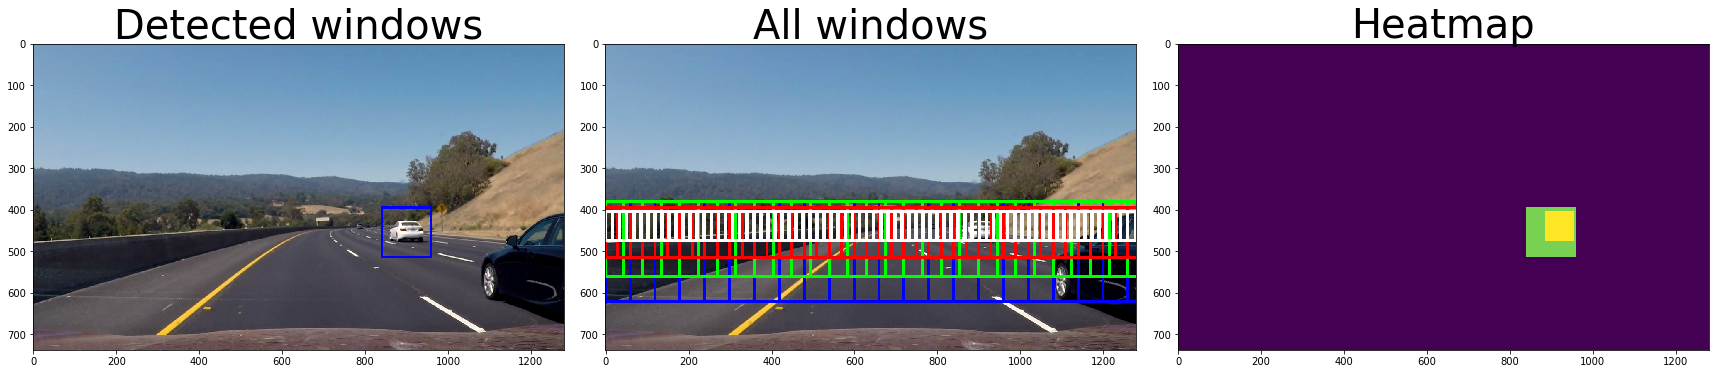

In [19]:
images = glob.glob('seq/seq*.png')
boxes = BoundingBoxes(n=6)

for file in images[1:5]:
    image = mpimg.imread(file)
    #image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    
    boxes.update(hot_windows)
    
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    
    
    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
    
    
    # Read in the last image shown above 
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,3)
    
    plt.figure()    
    # Plot the result
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=40)
    
    ax3.imshow(heatmap)
    ax3.set_title('Heatmap', fontsize=40)

plt.show()

1 cars found


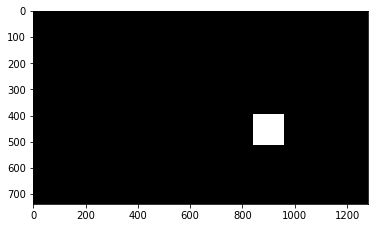

In [20]:
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

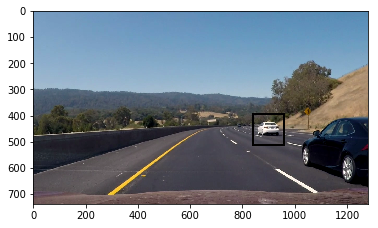

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread(images[5])
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)
plt.show()

In [22]:
boxes = BoundingBoxes(n=30)

def process_image(image):
    draw_image = np.copy(image)    
    image = image.astype(np.float32)/255
    hot_windows,_ = search_all_scales(image)
    boxes.update(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,20)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    
    #window_image = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)
    return window_image

In [23]:
out_dir='./output_images/'
inpfile='project_video.mp4'
outfile=out_dir+'processed_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(outfile, audio=False)


[MoviePy] >>>> Building video ./output_images/processed_project_video.mp4
[MoviePy] Writing video ./output_images/processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:31<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_project_video.mp4 

Wall time: 19min 33s


# Discussion

Pipeline works at the whole but it has some faults. That's why I will make some improvements:
1. I'd like to implement YOLO Real-Time Object Detection. This technics could be faster:
https://pjreddie.com/darknet/yolo/
2. My CarND Vehicle Detection implementation still have some false positives and undetected vehicles. Thus I am going to check parameters and tune the model. Also I am going to use more labeled data.